In [6]:
from torch import nn
import torch


def unsorted_segment_sum(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)


def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges


def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr


class E_GCL(nn.Module):
    """
    E(n) Equivariant Convolutional Layer
    re
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, act_fn=nn.SiLU(), residual=True, attention=False, normalize=False, coords_agg='mean', tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.residual = residual
        self.attention = attention
        self.normalize = normalize
        self.coords_agg = coords_agg
        self.tanh = tanh
        self.epsilon = 1e-8
        edge_coords_nf = 1

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
        self.coord_mlp = nn.Sequential(*coord_mlp)

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.residual:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        if self.coords_agg == 'sum':
            agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        elif self.coords_agg == 'mean':
            agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        else:
            raise Exception('Wrong coords_agg parameter' % self.coords_agg)
        coord = coord + agg
        return coord

    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum(coord_diff**2, 1).unsqueeze(1)

        if self.normalize:
            norm = torch.sqrt(radial).detach() + self.epsilon
            coord_diff = coord_diff / norm

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr


In [7]:
class EGNN(nn.Module):
    def __init__(self, in_node_nf, hidden_nf, out_node_nf, in_edge_nf=0, device='cpu', act_fn=nn.SiLU(), n_layers=4, residual=True, attention=False, normalize=False, tanh=False):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        self.embedding_in = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf,
                                                act_fn=act_fn, residual=residual, attention=attention,
                                                normalize=normalize, tanh=tanh))
        self.to(self.device)

    def forward(self, h, x, edges, edge_attr):
        h = self.embedding_in(h)
        for i in range(0, self.n_layers):
            h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_attr=edge_attr)
        h = self.embedding_out(h)
        return h, x


等变性（equivariance）在这里指的是，对输入进行某种变换（在这里是旋转），然后再通过模型进行计算，应该与先通过模型计算再对输出进行同样的变换达到相同的效果。这是等变性的基本定义。

In [8]:
from e3nn import o3
import torch
from torch import nn
import torch.nn.functional as F
import math

# 假设你的 EGNN 类和 get_edges_batch 函数已经定义
# from your_egnn_module import EGNN, get_edges_batch

# 随机生成旋转矩阵
rot = o3.rand_matrix()

# 创建旋转矩阵

angle = math.radians(45)  # 将角度转换为弧度

rotation_matrix = torch.tensor([
    [math.cos(angle), -math.sin(angle)],
    [math.sin(angle), math.cos(angle)]
])

# 初始化虚拟变量
batch_size = 1
n_nodes = 3
n_feat = 3
v_dim = 2
h = torch.randn(batch_size *  n_nodes, n_feat)
v = torch.randn(batch_size * n_nodes, v_dim)


print(h.shape, v.shape)
edges, edge_attr = get_edges_batch(n_nodes, batch_size)

print("edges shape, edge_attr.shape", len(edges), edge_attr.shape)

# 初始化 EGNN
egnn = EGNN(in_node_nf=n_feat, hidden_nf=32, out_node_nf=3, in_edge_nf=1)


h1, v1 = egnn(h, v, edges, edge_attr)

# 旋转并传递通过模型
v_rot_tensor =  torch.mm(v, rotation_matrix.T)  # 转置矩阵用于反向旋转

h_rot, v_rot = egnn(h, v_rot_tensor, edges, edge_attr)

# 旋转模型的初始输出
h1_rot = h1 @ rot
v1_rot = v_rot_tensor =  torch.mm(v1, rotation_matrix.T)  # 转置矩阵用于反向旋转

# 检查网络是否等变
print("h1\n", h1)
print("h1 @ rot\n", h1_rot)
print("h_rot\n", h_rot)

print("v1\n", v1)
print("v1 @ rot\n", v1_rot)
print("v_rot\n", v_rot)

print("Are h1 @ rot and h_rot close?", torch.allclose(h1_rot, h_rot, atol=1e-6))
print("Are v1 @ rot and v_rot close?", torch.allclose(v1_rot, v_rot, atol=1e-6))


torch.Size([3, 3]) torch.Size([3, 2])
edges shape, edge_attr.shape 2 torch.Size([6, 1])
h1
 tensor([[ 0.7262, -0.1118,  0.1525],
        [ 0.8830, -0.2530, -0.2216],
        [ 0.9893, -0.5261,  0.2272]], grad_fn=<AddmmBackward0>)
h1 @ rot
 tensor([[ 0.6696,  0.3035, -0.1504],
        [ 0.9154, -0.0394, -0.2310],
        [ 1.0882,  0.3315,  0.1152]], grad_fn=<MmBackward0>)
h_rot
 tensor([[ 0.7262, -0.1118,  0.1525],
        [ 0.8830, -0.2530, -0.2216],
        [ 0.9893, -0.5261,  0.2272]], grad_fn=<AddmmBackward0>)
v1
 tensor([[ 0.4923,  2.0411],
        [ 1.3240, -0.7226],
        [ 1.5588, -0.9558]], grad_fn=<AddBackward0>)
v1 @ rot
 tensor([[-1.0952,  1.7914],
        [ 1.4472,  0.4252],
        [ 1.7780,  0.4264]], grad_fn=<MmBackward0>)
v_rot
 tensor([[-1.0952,  1.7914],
        [ 1.4472,  0.4252],
        [ 1.7780,  0.4264]], grad_fn=<AddBackward0>)
Are h1 @ rot and h_rot close? False
Are v1 @ rot and v_rot close? True


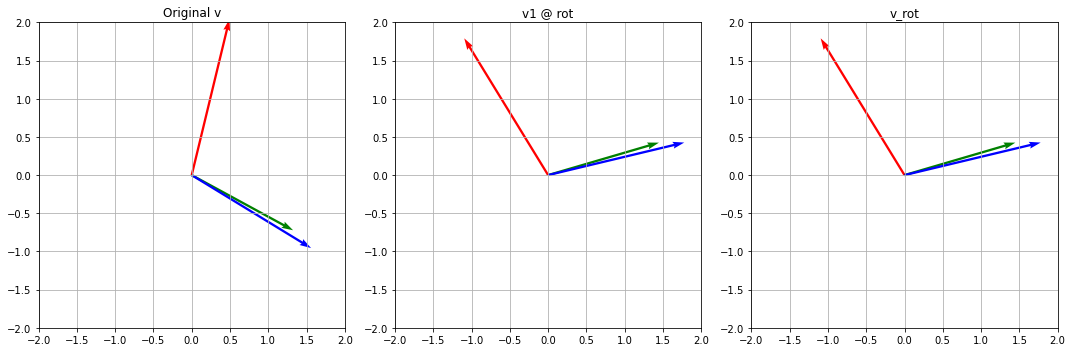

In [9]:
import matplotlib.pyplot as plt

def visualize_vector(ax, v, title):
    ax.quiver(0, 0, v[0, 0], v[0, 1], angles='xy', scale_units='xy', scale=1, color='r')
    ax.quiver(0, 0, v[1, 0], v[1, 1], angles='xy', scale_units='xy', scale=1, color='g')
    ax.quiver(0, 0, v[2, 0], v[2, 1], angles='xy', scale_units='xy', scale=1, color='b')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(title)
    ax.grid(True)

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Visualize original v
visualize_vector(axes[0], v.detach().numpy(), "Original v")

# Visualize v1 @ rot
visualize_vector(axes[1], v1_rot.detach().numpy(), "v1 @ rot")

# Visualize v_rot
visualize_vector(axes[2], v_rot.detach().numpy(), "v_rot")

# Display the figure
plt.tight_layout()
plt.show()
